# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

## Functions

In [2]:
def _get_nulls(feats):
    null_map = {}
    for idx, row in feats.iterrows():
        str_nulls = row['missing_or_unknown'].strip('[]')
        if len(str_nulls) > 0:  # Check for empty
            try:
                nulls = [int(i) for i in str_nulls.split(',')]
            except ValueError:  # non int val
                nulls = [i for i in str_nulls.split(',')]
            null_map[row['attribute']] = nulls
    return null_map

def _clean_feature(df, key, nulls):
    is_int = True
    for null in nulls:
        if type(null) == str:
            is_int = False
        df.loc[df[key] == null, key] = np.nan
    return df

def convert_nans(df: pd.DataFrame, feats: pd.DataFrame) -> pd.DataFrame:
    """Convert nans using Feature maps from dataframe"""
    df = df.copy()
    null_map = _get_nulls(feats)
    for key, nulls in null_map.items():
        df = _clean_feature(df, key, nulls)
    return df


def test_convert_nans():
    feat_df = pd.DataFrame({'attribute': [0, 1],
                            1: ['', ''],
                            2: ['', ''],
                            'missing_or_unknown': ['[-1,0, 9,   99]', '[-1,0]']})
    df = pd.DataFrame({0: [-1, -1, -1, 1, 2, 3, 99],
                       1: [-1, -1,  0, 1, 2, 3,  4]})
    out = convert_nans(df, feat_df)
    exp = pd.DataFrame({0: [np.nan, np.nan, np.nan, 1, 2, 3, np.nan],
                        1: [np.nan, np.nan, np.nan, 1, 2, 3, 4]})
    # row 0
    for i in range(3):
        assert pd.isnull(out.iloc[i, 0])
    for i in range(3, len(df.index)-1):
        assert not pd.isnull(out.iloc[i, 0])
    assert pd.isnull(out.iloc[-1, 0])

    # row 1
    for i in range(3):
        assert pd.isnull(out.iloc[i, 1])
    for i in range(3, len(df.index)):
        assert not pd.isnull(out.iloc[i, 1])
        

test_convert_nans()

def get_na_freq(df, axis=0):
    """Collect Frequency of NaN Values"""
    if axis == 0 :
        total = len(df.index)
    else:
        total = len(df.columns)
    df = df.copy()
    na_hist = df.isna().sum(axis=axis).sort_values(ascending=False)
    if axis == 0:
        na_hist.index.name = 'Attribute'
    else:
        na_hist.index.name = 'Index'
    na_hist.name = 'Freq'
    na_hist = na_hist.to_frame()
    na_hist = na_hist.assign(Percent=lambda df: df['Freq'] / total * 100)
    na_hist = na_hist.reset_index()
    return na_hist

def remove_empty_cols(df, top_n, axis=0):
    """remove top_n attributes with most frequent NaN Values"""
    df = df.copy()
    na_hist = get_na_freq(df, axis=axis)
    if axis == 0:
        na_attrs = na_hist['Attribute'].values
        drop_axis=1
    else:
        na_attrs = na_hist['Index'].values
        drop_axis=0
    
    df = df.drop(na_attrs[:top_n], axis=drop_axis)
    dropped_attrs = na_attrs[:top_n]
    return df, dropped_attrs

def split_on_nan(df: pd.DataFrame, threshold: float):
    """Split data into two data sets based on number of missing values"""
    left_idx = df.isna().sum(axis=1) <= threshold
    right_idx = df.isna().sum(axis=1) > threshold

    left_df = df.loc[left_idx, :]
    right_df = df.loc[right_idx, :]
    
    return left_df.copy(), right_df.copy()


def test_split_on_nan():
    th = 2
    df = pd.DataFrame({0: [np.nan, np.nan, np.nan, 1, 2, 3, np.nan],
                       1: [np.nan, np.nan, np.nan, 1, 2, 3,      4],
                       2: [np.nan, np.nan,      0, 1, 2, 3,      4],
                       3: [     1, np.nan,      0, 1, 2, 3,      4],
                       4: [     2,      3,      0, 1, 2, 3,      4]})
    df1, df2 = split_on_nan(df, th)
    assert df1.isna().sum(axis=1).max() == th
    assert df2.isna().sum(axis=1).max() > th
    assert df2.isna().sum(axis=1).max() == 4
    
test_split_on_nan()

def get_categorical_cols(feat_info, data, *, cat_type='categorical') -> list:
    """Gather Categorical Columns that exist in data"""
    cat_info = feat_info.query(f'type == "{cat_type}"')
    cat_keys = cat_info['attribute'].values
    cat_keys = [col for col in cat_keys if col in data.columns]
    return cat_keys

def get_num_categories(df, cat_keys):
    """Return number of categories per list of keys, `cat_keys`"""
    return pd.Series({col: len(df[col].unique()) for col in cat_keys}, name='n_categories')


def test_get_categorical_cols():
    def test_out(out, leng, exp_list):
        assert len(out) == leng
        for e in exp_list:
            assert e in out
            
            
    df = pd.DataFrame({
        'bin_1': [1, 2, 1, 2, 1, 2],
        'bin_2': [3, 4, 4, 3, 4, 4],
        'mul_1': [1, 2, 3, 4, 1, 2],
        'mul_2': [9, 8, 7, 9, 8, 7],
        'other': [2, 3, 9, 8, 7, 3.3],
    })
    cat_types = ['categorical', 'categorical', 'categorical', 'mixed', 'other']
    
    f_info = pd.DataFrame({}, columns=['attribute', 'type', 'other_val'])
    for i, (name, c_type) in enumerate(zip(df.columns, cat_types)):
        f_info.loc[i] = [name, c_type, np.nan]
    
    # test default
    out = get_categorical_cols(f_info, df)
    test_out(out, leng=3, exp_list=['bin_1', 'bin_2', 'mul_1'])
    
    # test option
    out2 = get_categorical_cols(f_info, df, cat_type='mixed')
    test_out(out2, leng=1, exp_list=['mul_2'])

test_get_categorical_cols()

def split_categories(n_categories: pd.DataFrame, *, cutoff1=2, cutoff2=10):
    low_cats = (n_categories[n_categories <= cutoff1]).index
    remaining = (n_categories[n_categories > cutoff1])
    mid_cats = (remaining[remaining <= cutoff2]).index
    high_cats = (remaining[remaining > cutoff2]).index
    return low_cats, mid_cats, high_cats


def test_split_categories():
    def test_out(out, ex1, ex2, ex3):
        out_l, out_m, out_h = out
        assert len(out_l) == ex1
        assert len(out_m) == ex2
        assert len(out_h) == ex3
        
    ser = pd.Series({
        'spam': 2,
        'ham':  3,
        'eggs': 5,
        'bacon': 10,
        'toast': 12,
    })
    out_default = split_categories(ser)
    test_out(out_default, ex1=1, ex2=3, ex3=1)
    out_options = split_categories(ser, cutoff1=3, cutoff2=5)
    test_out(out_options, ex1=2, ex2=1, ex3=2)

test_split_categories()

def get_multi_dummies(df, multi_cats, bin_cats, *, drop_cats=[]):
    b_df = df[bin_cats]
    o_df = df.drop(bin_cats, axis=1).drop(drop_cats, axis=1)
    b_dummies = pd.get_dummies(b_df, sparse=False, drop_first=True, columns=bin_cats)
    o_dummies = pd.get_dummies(o_df, sparse=False, columns=multi_cats)
    return pd.concat([o_dummies, b_dummies], axis=1)

def test_get_multi_dummies():
    def test_out(out, exp_mul, exp_bin, exp_other):
        assert len(out.columns) == exp_mul + exp_bin + exp_other
        for exp, enum in zip((exp_mul, exp_bin, exp_other),
                             ('mul', 'bin', 'other')):
            assert len([col for col in out.columns if  enum in col]) == exp
    df = pd.DataFrame({
        'bin_1': [1, 2, 1, 2, 1, 2],
        'bin_2': [3, 4, 4, 3, 4, 4],
        'mul_1': [1, 2, 3, 4, 1, 2],
        'mul_2': [9, 8, 7, 9, 8, 7],
        'other': [2, 3, 9, 8, 7, 3.3],
    })
    m_cats = ['mul_1', 'mul_2']
    b_cats = ['bin_1', 'bin_2']
    
    exp_total = 10
    exp_mul = 7
    exp_bin = 2
    exp_other = 1
    # test default
    out = get_multi_dummies(df, m_cats, b_cats)
    test_out(out, exp_mul, exp_bin, exp_other)
    excluded = ['other']
    # Test col removal
    out2 = get_multi_dummies(df, m_cats, b_cats, drop_cats=excluded)
    exp_other = 0
    test_out(out2, exp_mul, exp_bin, exp_other)
    
test_get_multi_dummies()

def map_unique_col(df: pd.DataFrame, col: str, mapping: dict, *, suffix='_map') -> pd.DataFrame:
    """Process unique col into encoding using mapping"""
    new_col = f'{col}{suffix}'
    i = 0
    while new_col in df.columns:
        if i == 0:
            new_col += f'_{i}'
        else:
            new_col = new_col[:-2] + f'_{i}'
    new_df = df.copy()
    new_df[new_col] = df[col].replace(mapping)
    return new_df
    

def test_process_unique_col():
    df = pd.DataFrame({
        'bin_1': [1, 2, 1, 2, 1, 2],
        'bin_2': [3, 4, 4, 3, 4, 4],
        'mul_1': [1, 2, 3, 4, 1, 2],
        'mul_2': [9, 8, 7, 9, 8, 7],
        'other': [2, 3, 9, 8, 7, 3],
    })
    col = 'other'
    mapping = {2: 0, 3: 0, 9: 1, 8: 1, 7: 1}
    out = map_unique_col(df, col, mapping)
    assert len(out[f'{col}_map']) == 6
    for e in (0,1):
        s = (out[f'{col}_map'] == e).sum()
        assert s == 3
test_process_unique_col()

def process_jugnedjahre_unique(data: pd.DataFrame) -> pd.DataFrame:
    """Process PRAEGENDE_JUGENDJAHRE in data"""
    year_map = {
        np.nan: np.nan,
        1: 4,
        2: 4,
        3: 5,
        4: 5,
        5: 6,
        6: 6,
        7: 6,
        8: 7,
        9: 7,
       10: 8,
       11: 8,
       12: 8,
       13: 8,
       14: 9,
       15: 9,
    }
    movement_map = {
         np.nan: np.nan,
         1: 0,
         2: 1,
         3: 0,
         4: 1,
         5: 0,
         6: 1,
         7: 1,
         8: 0,
         9: 1,
        10: 0,
        11: 1,
        12: 0,
        13: 1,
        14: 0,
        15: 1,
    }

    new_df = data.copy()
    for name, mapping in [('decade', year_map), ('movement', movement_map)]:
        new_df = map_unique_col(new_df, 'PRAEGENDE_JUGENDJAHRE', mapping, suffix=f'_{name}')
    new_df = new_df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    return new_df

def process_cameo_unique(df: pd.DataFrame) -> pd.DataFrame:
    """Process CAMEO_INTL_2015 data into ..._income and ..._life_stage columns dropping original"""
    return (df.assign(CAMEO_INTL_2015_income=lambda df: df['CAMEO_INTL_2015'].str[0].astype('float'),
                        CAMEO_INTL_2015_life_stage=lambda df: df['CAMEO_INTL_2015'].str[-1].astype('float'))
              .drop(['CAMEO_INTL_2015'], axis=1))

def process_wohnlage_unique(df: pd.DataFrame) -> pd.DataFrame:
    col = 'WOHNLAGE'
    
    rural_map = {i: 0 for i in range(6)}
    rural_map[7] = 1
    rural_map[8] = 1
    
    quality_map = {i: np.nan for i in [7,8]}
    
    new_df = df.copy()
    
    for mapping, suffix in [(rural_map, '_rural'), (quality_map, '_location_quality')]:
        new_df = map_unique_col(new_df, col, mapping, suffix=suffix)
    return new_df.drop([col], axis=1)

    
def process_plz8_unique(df: pd.DataFrame) -> pd.DataFrame:
    col = 'PLZ8_BAUMAX'
    bus_map = {i: 0 for i in range(5)}
    bus_map[5] = 1
    fam_map = {5: np.nan}
    
    new_df = df.copy()
    for mapping, suffix in [(bus_map, '_business'), (fam_map, '_housing_size')]:
        new_df = map_unique_col(new_df, col, mapping, suffix=suffix)
    return new_df.drop([col], axis=1)


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
from IPython.display import display
print('AZDIAS len:', len(azdias))
display(azdias.head())

print('Feat info :', len(feat_info))
display(feat_info.head())

AZDIAS len: 891221


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Feat info : 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
azdias = convert_nans(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.


In [8]:
na_hist = get_na_freq(azdias)

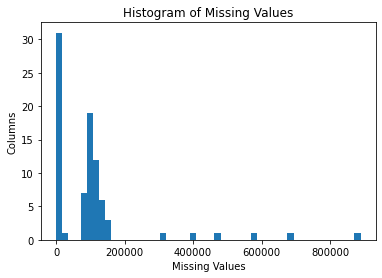

In [9]:
plt.hist(na_hist.set_index('Attribute')['Freq'], bins=50)
plt.xlabel('Missing Values')
plt.ylabel('Columns')
plt.title('Histogram of Missing Values')
plt.show()

In [10]:
# Investigate patterns in the amount of missing data in each column.


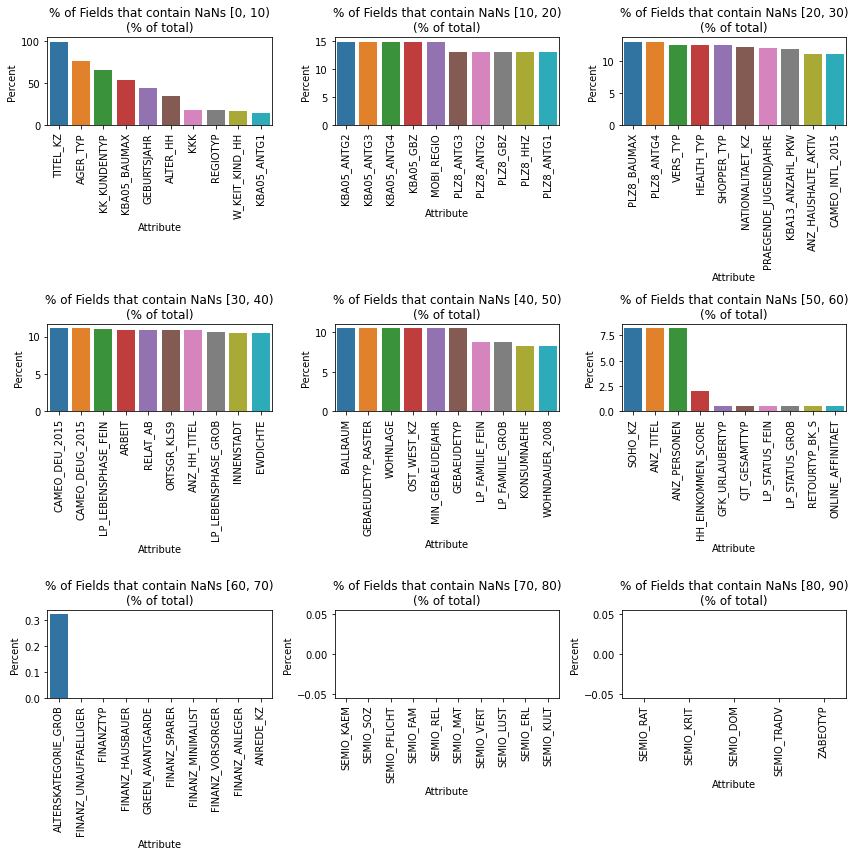

In [11]:
na_hist = get_na_freq(azdias)
dim = (3,3)
fig, axs = plt.subplots(dim[0],dim[1], tight_layout=True, figsize=(12,12))
for i in range(dim[0]*dim[1]):
    ax = plt.subplot(dim[0],dim[1], i+1)
    sns.barplot(x='Attribute', y='Percent', 
                data=na_hist.iloc[(i*10):((i+1)*10), :], ax=ax)  
                #, ax=axs[i//3,i%3])
    plt.xticks(rotation=90)
    ax.set_title(
        f'% of Fields that contain NaNs [{i*10}, {(i+1)*10})\n(% of total)'
    )

plt.show()


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [13]:
top_n = 6
azdias, dropped_cols = remove_empty_cols(azdias, top_n)
print('Removed following fields:\n', na_hist.iloc[:top_n, :]['Attribute'])
azdias.head()

Removed following fields:
 0        TITEL_KZ
1        AGER_TYP
2    KK_KUNDENTYP
3    KBA05_BAUMAX
4     GEBURTSJAHR
5        ALTER_HH
Name: Attribute, dtype: object


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

*[ACM] 6 fields were removed which contained a large % of missing data. TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH all contained missing values > 20% of the entire dataset. Of the remaining fields, missing data does still exists, but is <20% of the corpus and can be managed while maintining statistical significance.*

---


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
na_hist_idx = get_na_freq(azdias, axis=1)

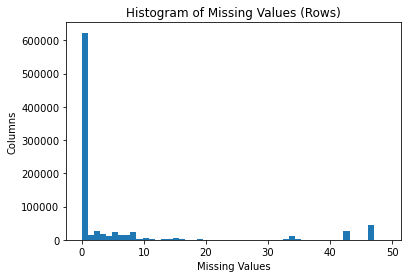

In [15]:
# How much data is missing in each row of the dataset?
plt.hist(na_hist_idx['Freq'], bins=50)
plt.xlabel('Missing Values')
plt.ylabel('Columns')
plt.title('Histogram of Missing Values (Rows)')
plt.show()


In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.



In [17]:
threshold = 2
filtered_azdias, df2 = split_on_nan(azdias, threshold)

In [18]:
na_hist_idx.head()

,Index,Freq,Percent
0,732775,49,62.025316
1,643174,49,62.025316
2,472919,48,60.759494
3,345274,47,59.493671
4,299868,47,59.493671


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.



In [20]:
def plot_data_split(df, threshold, attribs=None, *, figsize=(12, 24)):
    """Plot data comparison when split given a threshold (using split_on_nan)"""
    l_df, r_df = split_on_nan(df, threshold=threshold)
    
    xdata = attribs
    
    fig, axs = plt.subplots(len(xdata), 2, figsize=figsize)
    for j in range(len(xdata)):
        for i, df in zip(range(2), (l_df, r_df)):
            sns.countplot(x=xdata[j], data=df, ax=axs[j, i])
    return fig

def plot_random_data_split(df, threshold, *, rows=5, figsize=(12, 24), seed=42):
    """
    Plot random data comparison when split given a threshold 
    (using split_on_nan)
    """
    np.random.seed(seed)
    idx = np.random.randint(len(df.columns), size=rows)
    xdata = df.columns[idx]
    
    fig = plot_data_split(df, threshold, attribs=xdata)
    return fig

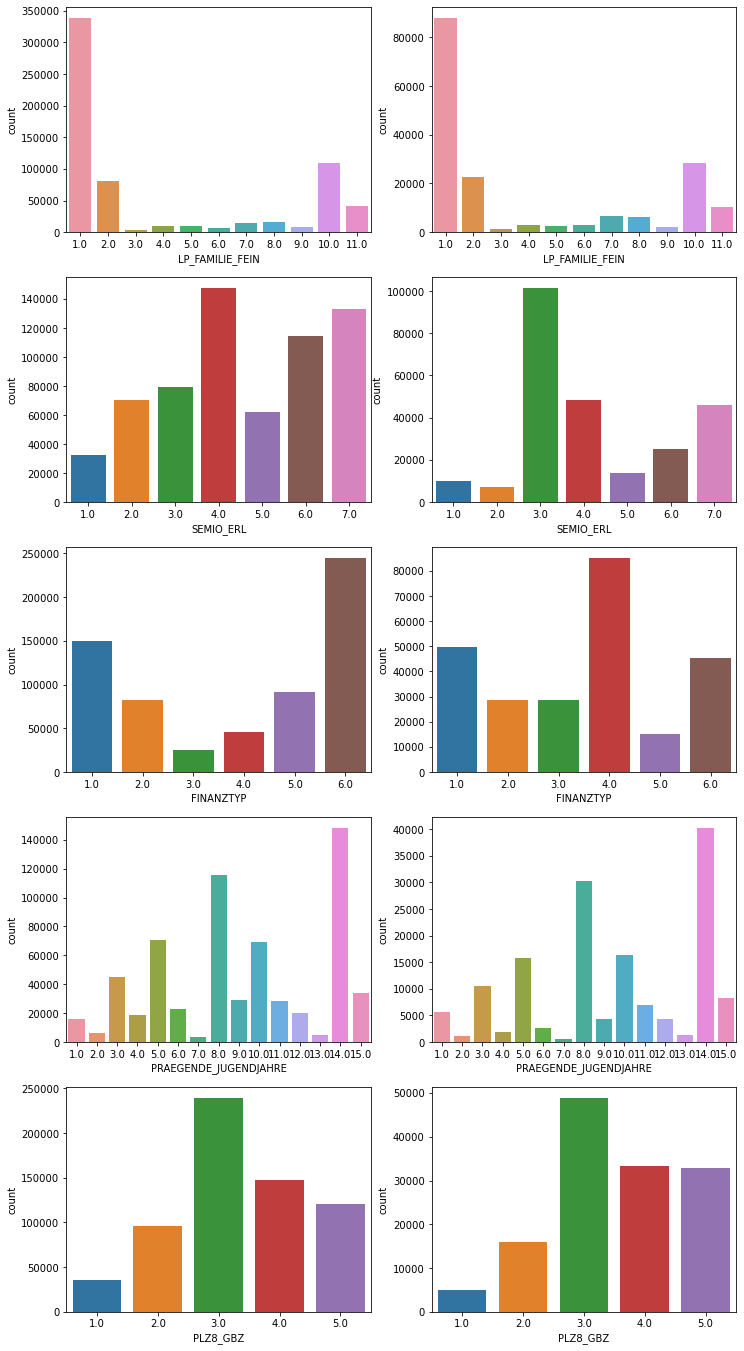

In [21]:
plot_random_data_split(azdias, 1);
azdias = filtered_azdias  # assign azdias to new filter after plotting resultant

In [24]:
print(f'number of discarded rows: {len(df2)}')
print(f'number of kept rows: {len(filtered_azdias)}')
print('Statistics of cleaned dataset: ')
display(filtered_azdias.describe().T)

print('Statistics of discarded dataset: ')
display(df2.describe().T)

number of discarded rows: 224348
number of kept rows: 666873
Statistics of cleaned dataset: 


,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,666873.0,2.800527,1.033430,1.0,2.0,3.0,4.0,4.0
ANREDE_KZ,666873.0,1.512865,0.499835,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,666873.0,3.461043,1.526737,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,666873.0,3.070738,1.363824,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,666873.0,2.664608,1.474004,1.0,1.0,2.0,4.0,5.0
...,...,...,...,...,...,...,...,...
PLZ8_HHZ,666873.0,3.611568,0.968041,1.0,3.0,3.0,4.0,5.0
PLZ8_GBZ,666873.0,3.366023,1.112856,1.0,3.0,3.0,4.0,5.0
ARBEIT,666805.0,3.187038,0.994153,1.0,3.0,3.0,4.0,5.0
ORTSGR_KLS9,666873.0,5.334092,2.300301,1.0,4.0,5.0,7.0,9.0


Statistics of discarded dataset: 


,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,221467.0,2.626802,0.923515,1.0,2.0,3.0,3.0,4.0
ANREDE_KZ,224348.0,1.549544,0.497540,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,219494.0,4.154792,1.682154,1.0,3.0,4.0,6.0,6.0
FINANZ_MINIMALIST,224348.0,3.085795,1.184776,1.0,3.0,3.0,4.0,5.0
FINANZ_SPARER,224348.0,3.286029,1.332552,1.0,2.0,4.0,4.0,5.0
...,...,...,...,...,...,...,...,...
PLZ8_HHZ,107833.0,3.620571,1.009813,1.0,3.0,4.0,4.0,5.0
PLZ8_GBZ,107833.0,3.474243,1.099216,1.0,3.0,3.0,4.0,5.0
ARBEIT,127041.0,3.059863,1.017857,1.0,2.0,3.0,4.0,5.0
ORTSGR_KLS9,127074.0,5.079780,2.307732,1.0,3.0,5.0,7.0,9.0


In [26]:
diff = filtered_azdias.describe() - df2.describe()

diff.loc['abs_error'] = np.abs(diff.loc['mean'])
diff.loc['abs_var'] = np.abs(diff.loc['std'])

print('Differnces by Mean:')
display(diff.sort_values('abs_error', axis=1, ascending=False))

print('Differences by STD:')
display(diff.sort_values('abs_var', axis=1, ascending=False))

Differnces by Mean:


,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,SEMIO_REL,FINANZ_UNAUFFAELLIGER,HH_EINKOMMEN_SCORE,SEMIO_SOZ,SEMIO_VERT,SEMIO_KRIT,FINANZ_ANLEGER,SEMIO_FAM,...,KBA05_ANTG3,GEBAEUDETYP_RASTER,REGIOTYP,FINANZ_MINIMALIST,RETOURTYP_BK_S,PLZ8_HHZ,NATIONALITAET_KZ,ANZ_HH_TITEL,SOHO_KZ,ANZ_TITEL
count,547269.000000,535673.000000,442525.000000,442525.000000,460873.000000,442525.000000,442525.000000,442525.000000,442525.000000,442525.000000,...,575849.000000,535676.000000,545277.000000,442525.000000,447379.000000,559040.000000,550840.000000,539533.000000,516024.000000,516024.000000
mean,-27.992293,-3.621022,-1.412975,-1.249271,1.120353,1.113825,1.083363,-1.058591,-0.987623,-0.761612,...,-0.027658,-0.026708,0.025307,-0.015058,-0.013817,-0.009003,-0.005052,-0.004434,0.000087,-0.000026
std,-23.927226,-4.552254,-0.170701,-0.033965,-0.059536,0.292325,-0.428531,-0.078181,-0.047358,0.135602,...,0.006636,-0.039609,-0.035991,0.179048,0.157937,-0.041772,-0.017327,-0.087852,0.000467,-0.002636
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.000000,0.000000,-1.000000,-2.000000,2.000000,0.000000,1.000000,-1.000000,-1.000000,-2.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-24.000000,0.000000,-3.000000,-3.000000,2.000000,2.000000,3.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
75%,-44.000000,-7.000000,-2.000000,-1.000000,1.000000,2.000000,1.000000,-1.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,-2.000000
abs_error,27.992293,3.621022,1.412975,1.249271,1.120353,1.113825,1.083363,1.058591,0.987623,0.761612,...,0.027658,0.026708,0.025307,0.015058,0.013817,0.009003,0.005052,0.004434,0.000087,0.000026
abs_var,23.927226,4.552254,0.170701,0.033965,0.059536,0.292325,0.428531,0.078181,0.047358,0.135602,...,0.006636,0.039609,0.035991,0.179048,0.157937,0.041772,0.017327,0.087852,0.000467,0.002636


Differences by STD:


,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ANZ_HAUSHALTE_AKTIV,LP_LEBENSPHASE_FEIN,SEMIO_PFLICHT,SEMIO_MAT,LP_STATUS_FEIN,FINANZTYP,SEMIO_VERT,SEMIO_RAT,...,SHOPPER_TYP,KKK,VERS_TYP,ORTSGR_KLS9,KBA05_ANTG3,PLZ8_ANTG3,ANZ_TITEL,ANREDE_KZ,PLZ8_ANTG2,SOHO_KZ
count,547269.000000,535673.000000,538512.000000,540153.000000,442525.000000,442525.000000,447379.000000,442525.000000,442525.000000,442525.000000,...,553721.000000,545277.000000,553721.000000,539799.000000,575849.000000,559040.000000,516024.000000,442525.000000,559040.000000,516024.000000
mean,-27.992293,-3.621022,0.340074,-0.052198,-0.549392,-0.685989,-0.228873,0.463229,1.083363,-0.271790,...,-0.225519,0.045367,0.128227,0.254312,-0.027658,0.108039,-0.000026,-0.036678,0.073491,0.000087
std,-23.927226,-4.552254,-1.739467,0.682537,0.623467,0.509234,0.477884,0.452756,-0.428531,0.409648,...,0.011414,-0.011177,0.008902,-0.007431,0.006636,0.004389,-0.002636,0.002294,0.001026,0.000467
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.000000,0.000000,1.000000,-1.000000,-1.000000,-2.000000,-1.000000,0.000000,1.000000,-1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-24.000000,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,1.000000,3.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,-44.000000,-7.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.000000,-11.000000,-59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000
abs_error,27.992293,3.621022,0.340074,0.052198,0.549392,0.685989,0.228873,0.463229,1.083363,0.271790,...,0.225519,0.045367,0.128227,0.254312,0.027658,0.108039,0.000026,0.036678,0.073491,0.000087
abs_var,23.927226,4.552254,1.739467,0.682537,0.623467,0.509234,0.477884,0.452756,0.428531,0.409648,...,0.011414,0.011177,0.008902,0.007431,0.006636,0.004389,0.002636,0.002294,0.001026,0.000467


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

*[ACM] Analyzing the data - there are a few outliers that contain a significant amount of missing data. Analysis of rows that contain 2 or greater empty fields were compared to the rest of the dataset and were separated as populations. Comparing 5 random fields, the distribution of each field were similar between populations. Further analysis compared the mean and standard distributions between the two populations showing that 2 fields, KBA13_ANZAHL_PKW and MIN_GEBAEUDEJAHR, contained mean differences greater than 1 unit. Further anlaysis may be required if these fields result in a strong weight to further analysis.*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?



In [27]:
n_feat_type = feat_info.groupby('type').count()['attribute']
n_feat_type.name = 'n_features'
display(n_feat_type.to_frame())

,n_features
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?



In [29]:
cat_keys = get_categorical_cols(feat_info, azdias)
print(f'Categorical Columns:\n{cat_keys}')

Categorical Columns:
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


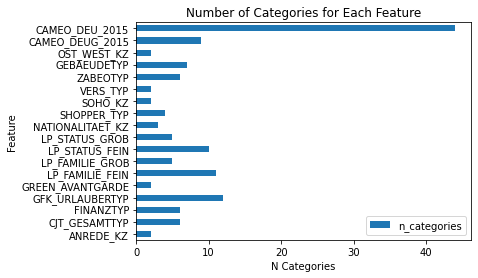

Binary Categories: ['ANREDE_KZ' 'GREEN_AVANTGARDE' 'SOHO_KZ' 'VERS_TYP' 'OST_WEST_KZ']


In [30]:
n_cats = get_num_categories(azdias, cat_keys)
binary_cats, multi_cats, _ = split_categories(n_cats, cutoff2=np.inf)
ax = n_cats.to_frame().plot(kind='barh')
ax.set_xlabel('N Categories')
ax.set_ylabel('Feature')
ax.set_title('Number of Categories for Each Feature')
plt.show()
binary_cats = (n_cats[n_cats == 2]).index
multi_cats = (n_cats[n_cats != 2]).index
print(f'Binary Categories: {binary_cats.values}')

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.



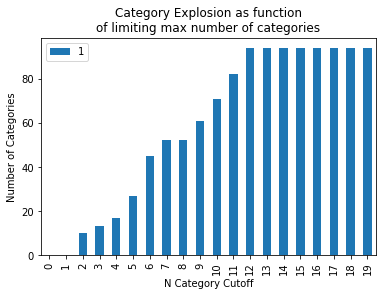

In [32]:
ax = pd.DataFrame([(i, n_cats[n_cats<=i].sum()) for i in range(20)]).plot(x=0, kind='bar')
ax.set_xlabel('N Category Cutoff')
ax.set_ylabel('Number of Categories')
ax.set_title('Category Explosion as function\nof limiting max number of categories')

plt.show()

In [33]:
upper_cutoff = 6
print(f'Steady increase in features at {upper_cutoff} categories per feature.')
print(f'Propose limiting analysis to features with <= {upper_cutoff} categories')

Steady increase in features at 6 categories per feature.
Propose limiting analysis to features with <= 6 categories


In [34]:
binary_cats, multi_cats, removed_cats = split_categories(n_cats, cutoff2=upper_cutoff)

In [35]:
azdias = get_multi_dummies(azdias, binary_cats, multi_cats, drop_cats=removed_cats)

In [36]:
print('Unique types of features in dataset:')
display(azdias.dtypes.unique())

Unique types of features in dataset:


array([dtype('float64'), dtype('O'), dtype('uint8')], dtype=object)

In [37]:
print(f'Binary Columns:\n{binary_cats}\n--\n')
print(f'Categorical Columns Kept:\n{multi_cats}\n--\n')
print(f'Omitted Categorical Columns:\n{removed_cats}\n--\n')

Binary Columns:
Index(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'], dtype='object')
--

Categorical Columns Kept:
Index(['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'],
      dtype='object')
--

Omitted Categorical Columns:
Index(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')
--



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

*[ACM] I limited the number of categorical features to features with 6 or less features, primarily due to the drastic increase in
features observed when encoding these catigorical features into one hot encoded features. Given the analysis, the binary features were One Hot Encoded where the first column was dropped to ensure [0,1] encoding and the categorical features with 6 or less features were one hot encoded. The categories that contained 7 or more features were dropped from the data set.*  

---

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


In [39]:
mixed_cols = get_categorical_cols(feat_info, azdias, cat_type='mixed')
display(mixed_cols)
keep_mixed = ['WOHNLAGE', 'PLZ8_BAUMAX'] 
drop_mixed = [col for col in mixed_cols if col not in 
              keep_mixed + ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']]
drop_mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']

In [40]:
azdias = process_jugnedjahre_unique(azdias)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.



In [42]:
azdias = process_cameo_unique(azdias)
azdias = (
    azdias.pipe(process_wohnlage_unique)
          .pipe(process_plz8_unique)
          .drop(drop_mixed, axis=1)
)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

*[ACM] The mixed type features, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were converted to single axis feature categories.
LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROS were dropped due to the similarity to PRAEGENDE_JUGENDJAHRE. The mixed
type feature, WOHNLAGE, was split into two features: WOHNLAGE_rural and WOHNLAGE_location_quality to capture the neighborhood
quality and rural flag data captured within the feature. Finally, PLZ8_BAUMAX was split into two features: PLZ8_BAUMAX_business 
and  PLZ8_BAUMAX_housing_size, to capture if the location is within a business area and the housing size flag within the feature.*

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [44]:
print('dtypes within the dataset:')
display(azdias.dtypes.unique())

dtypes within the dataset:


array([dtype('float64'), dtype('uint8')], dtype=object)

In [45]:
print('Data Cleaned and handled - NOTE the threshold for NaNs may be too '
      +'optimisitic')

Data Cleaned and handled - NOTE the threshold for NaNs may be too optimisitic


In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline


def clean_data(df, min_nan_col=6, min_nan_row=2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_file = Path.cwd() / 'AZDIAS_Feature_Summary.csv'
    feat_info = pd.read_csv(feat_file, delimiter=';')

    nan_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP',
                'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    categories = {'binary': ['ANREDE_KZ', 'GREEN_AVANTGARDE'],
                  'multi':  ['FINANZTYP', 'LP_FAMILIE_GROB', 
                             'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                             'SHOPPER_TYP', 'SOHO_KZ', 
                             'VERS_TYP', 'ZABEOTYP', 'OST_WEST_KZ'],
                  # add multi with category - still will be removed
                  'remove': ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 
                             'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                             'GEBAEUDETYP', 'CAMEO_DEUG_2015',
                             'CAMEO_DEU_2015'] + 
                            ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']}  
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = df.copy()
    df = convert_nans(df, feat_info)

    # remove selected columns and rows, ...
    
    df = df.drop(nan_cols, axis=1)
    df = get_multi_dummies(df,
                           multi_cats=categories['multi'],
                           bin_cats=categories['binary'], 
                           drop_cats=categories['remove'])

    
    # select, re-encode, and engineer column values.
    df = (df.pipe(process_jugnedjahre_unique)
            .pipe(process_cameo_unique)
            .pipe(process_wohnlage_unique)
            .pipe(process_plz8_unique)
    )
    df, _ = split_on_nan(df, min_nan_row)
    # Return the cleaned dataframe.
    return df
    

In [48]:
azdias_clean = (
    pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
    .pipe(lambda df: clean_data(df, min_nan_row=0))
)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [50]:
azdias_clean.isna().sum(axis=1).max()

0

In [51]:
# Apply feature scaling to the general population demographics data.



In [98]:
preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
azdias_scaled = preproc.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

*[ACM] For scaling, I created a Pipeline first with a SimpleImputer with a median strategy to filter nan values 
to the most common value - a step unecessary for the current dataset, but may be necessary and is good practice
for future datasets. The second step I used to preprocess the data was a StandardScaler to scale all of the values
to 0 mean and 1 standard deviation to prevent any uneven results between features when performing future steps 
(such as PCA)*

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [99]:
# Apply PCA to the data.

In [102]:
pca = PCA()
res = pca.fit_transform(azdias_scaled)

In [103]:
# Investigate the variance accounted for by each principal component.

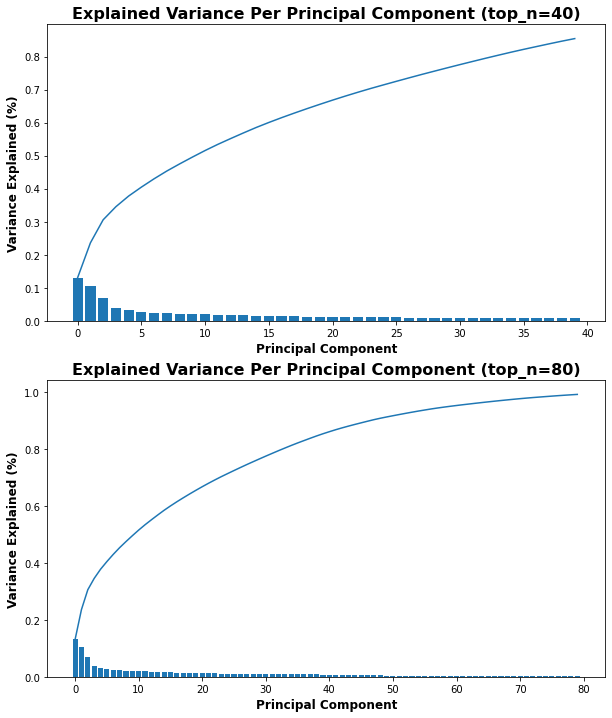

In [104]:
vars = pca.explained_variance_ratio_
n = 80
fig, axs = plt.subplots(2,1, figsize=(10,12))
for i, n in enumerate([40, 80]):
    
    # Citation - Components dirived form Interpret_PCA_Results from Udacity's
    # Machine Learning Oourse
    axs[i].bar(range(n), vars[:n])
    axs[i].plot(range(n), vars.cumsum()[:n])
    axs[i].set_ylabel('Variance Explained (%)',
                 fontweight='bold', 
                 fontsize=12)
    axs[i].set_xlabel('Principal Component', 
                 fontweight='bold', 
                 fontsize=12)
    axs[i].set_title(f'Explained Variance Per Principal Component (top_n={n})', 
                 fontweight='bold', 
                 fontsize=16)
plt.show()

In [105]:
# Re-apply PCA to the data while selecting for number of components to retain.

In [106]:
pipeline_pca = PCA(n_components=40)
data = pipeline_pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

*[ACM] The 40% of the variance is explained by the first 5 components, however there is a significant tail to the data, where the next 40% is explained by the next ~35 components (40 total) and the last ~20% is explained by the next ~40 components (80 total)). In an effort to retain 80% of the variance, 40 components will be retained, but a more aggrestive decomposition to retain 20 or even 10 components may be appropriate*

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [107]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [172]:
def get_feature_translation(file: str) -> dict:
    """Return a translation of features"""
    feats = {}
    read_next = False
    with open(file, 'r') as fh:
        for line in fh.readlines():
            if line.startswith('###'):
                read_next = True
                key = line.strip('###').split('.')[-1].strip()
                feats[key] = None
            elif read_next:
                feats[key] = line.strip()
                read_next = False
    return feats
        

In [174]:
feats = get_feature_translation('Data_Dictionary.md')
feats

{'Table of Contents': '',
 'AGER_TYP': 'Best-ager typology',
 'ALTERSKATEGORIE_GROB': 'Estimated age based on given name analysis',
 'ANREDE_KZ': 'Gender',
 'CJT_GESAMTTYP': 'Customer-Journey-Typology: preferred information and buying channels for',
 'FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,': None,
 'FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER': 'Financial typology, for each dimension:',
 'FINANZTYP': 'Most descriptive financial type for individual',
 'GEBURTSJAHR': 'Year of birth',
 'GFK_URLAUBERTYP': 'Vacation habits',
 'GREEN_AVANTGARDE': 'Membership in environmental sustainability as part of youth',
 'HEALTH_TYP': 'Health typology',
 'LP_LEBENSPHASE_FEIN': 'Life stage, fine scale',
 'LP_LEBENSPHASE_GROB': 'Life stage, rough scale',
 'LP_FAMILIE_FEIN': 'Family type, fine scale',
 'LP_FAMILIE_GROB': 'Family type, rough scale',
 'LP_STATUS_FEIN': 'Social status, fine scale',
 'LP_STATUS_GROB': 'Social status, rough scale',
 'NATIONALITAET_KZ': 'Nationality base

In [152]:
def get_pc_weight(model_components, corresponding_names):
    dict = {col: weight for col, weight in 
            zip(corresponding_names, model_components)}
    ser = pd.Series(dict, name='mse')
    ser = ser.sort_values(ascending=False)
    return ser

In [153]:
s = get_pc_weight(pipeline_pca.components_[0], azdias_clean.columns)
s
# Pos
#  Rough social status
#  Money Saver
#  Wealth

# Neg
#   Low financial Interst
#   Movement Patters
#   1-2 Family cells


LP_STATUS_GROB_1.0        0.194030
HH_EINKOMMEN_SCORE        0.192975
FINANZ_SPARER             0.189556
CAMEO_INTL_2015_income    0.168030
PLZ8_ANTG3                0.159279
                            ...   
ALTERSKATEGORIE_GROB     -0.165912
KBA05_GBZ                -0.166066
KBA05_ANTG1              -0.183725
MOBI_REGIO               -0.189275
FINANZ_MINIMALIST        -0.224340
Name: mse, Length: 100, dtype: float64

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [156]:
s = get_pc_weight(pipeline_pca.components_[1], azdias_clean.columns)
s
# Pos
#  Est Age given Name
#  Energy Consumption
#  Personality: Event

# Neg
#   Personality: Religious
#   Movement by decade - Age
#   Financial: Inconspicuous


ALTERSKATEGORIE_GROB            0.200169
ZABEOTYP_3.0                    0.197493
SEMIO_ERL                       0.183033
FINANZ_VORSORGER                0.177255
RETOURTYP_BK_S                  0.152960
                                  ...   
SEMIO_PFLICHT                  -0.181476
SEMIO_TRADV                    -0.185141
FINANZ_UNAUFFAELLIGER          -0.196759
PRAEGENDE_JUGENDJAHRE_decade   -0.199679
SEMIO_REL                      -0.200806
Name: mse, Length: 100, dtype: float64

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

In [155]:
s = get_pc_weight(pipeline_pca.components_[2], azdias_clean.columns)
s
# Pos
#  Personality: dreamful
#  Personality: Family-minded
#  Personality: cultural-minded

# Neg
#   Gender
#   Personality: Combative attitude
#   Personality: Dominant-minded


SEMIO_VERT       0.323857
SEMIO_SOZ        0.258674
SEMIO_FAM        0.254795
SEMIO_KULT       0.236244
FINANZTYP_5.0    0.142009
                   ...   
SEMIO_ERL       -0.184565
SEMIO_KRIT      -0.259829
SEMIO_DOM       -0.316345
SEMIO_KAEM      -0.327374
ANREDE_KZ_2.0   -0.349182
Name: mse, Length: 100, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

*[ACM] Reviewing the first three principle components, it seems that the most 
important aspect is most closely associated with financial status. The second 
principle component seems to be convolved between age, spending patters, and if 
individual is not religous. The third component seems to be strongly tied to a 
family driven personality absent of type-A personalities*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [176]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [178]:
rand1000 = [np.random.randint(0, len(data)) for _ in range(1000)]

In [183]:
subset = data[rand1000, :]

In [226]:
def get_kmeans_score(X, n) -> tuple['score', 'model']:
    """Return tuple of socre and model given data, X, and number of clusters, n
    """
    clf = MiniBatchKMeans(n_clusters=n).fit(X)
    return clf.score(X), clf

In [242]:
np.arange(5, 31, 2)

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [228]:
res = [get_kmeans_score(data, n) for n in np.arange(5, 31, 2)]

In [230]:
scores, clfs = zip(*res)
clusters = [clf.n_clusters for clf in clfs]

# Since scores are the -SSE the mean distance should be approx sqrt(-score)
mean_dist = [np.sqrt(-score) for score in scores]

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



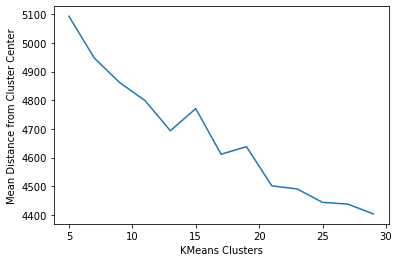

In [241]:
ax = plt.subplot(1,1,1)
ax.plot(clusters, mean_dist)
ax.set_xlabel('KMeans Clusters')
ax.set_ylabel('Mean Distance from Cluster Center')
plt.show()

In [263]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
try:
    # previous model already fit with demographics data
    idx = clusters.index(21)
    pipeline_kmeans = clfs[idx]
except NameError:
    # refit if cells were skipped
    pipeline_kmeans = MiniBatchKMeans(n_clusters=21)
    pipeline_kmeans.fit(data)
results = pipeline_kmeans.predict(data)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

*[ACM] Interpreting the data, there seems to be a knee (change in derivative)
within the curve at 13 and 21 clusters. Given the guidance that the number of 
clusters should be below 30 and there seems to be diminishing results from 
increased number of clusters > 21, I have chosen to select 21 clusters for the 
KMeans model.*

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [253]:
# Load in the customer demographics data.
customers = (
    pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
    .pipe(lambda df: clean_data(df, min_nan_row=np.inf)) 
    # prevent removal of data - use imputer below
)

In [254]:
customers.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_income,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_location_quality,PLZ8_BAUMAX_business,PLZ8_BAUMAX_housing_size
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,0,1,5.0,1.0,1.0,3.0,1.0,NaN,0.0,1.0
1,4.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,NaN,3.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,1,1,5.0,1.0,3.0,4.0,0.0,2.0,0.0,3.0
3,4.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,3.0,6.0,...,0,0,4.0,0.0,2.0,4.0,1.0,NaN,0.0,1.0
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,0,0,7.0,0.0,4.0,1.0,0.0,3.0,0.0,2.0


In [259]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_data = preproc.transform(customers)
customer_data = pipeline_pca.transform(customer_data)
customer_results = pipeline_kmeans.predict(customer_data)

In [262]:
display(customer_results[:10])

array([1, 7, 3, 7, 4, 1, 1, 1, 9, 1])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

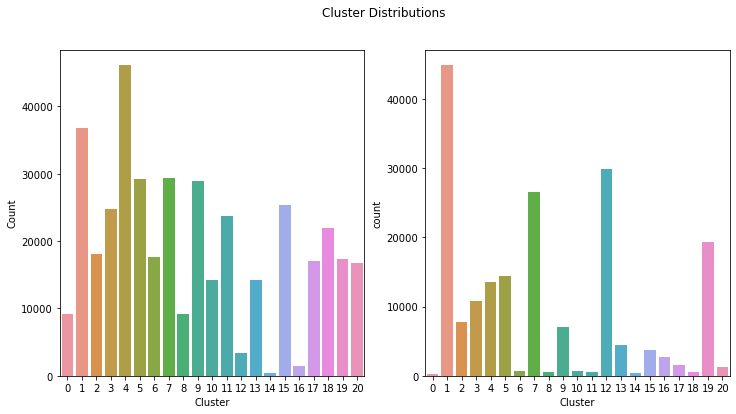

In [274]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x=results, ax=axs[0])
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')
sns.countplot(x=customer_results, ax=axs[1])
axs[1].set_xlabel('Cluster')
# fig.tight_layout()
fig.suptitle('Cluster Distributions')
plt.show()

In [275]:
from collections import Counter

In [278]:
global_cnts = Counter(results)
customer_cnts = Counter(customer_results)

In [283]:
def get_percent_pop(data) -> Counter:
    """Return a Counter Dict with percent population of each idx"""
    cnts = Counter(data)
    percent_cnts = {idx: cnt/len(data) for idx, cnt in cnts.most_common()}
    return Counter(percent_cnts)

In [287]:
global_percent, customer_percent = map(get_percent_pop, 
                                       (results, customer_results))

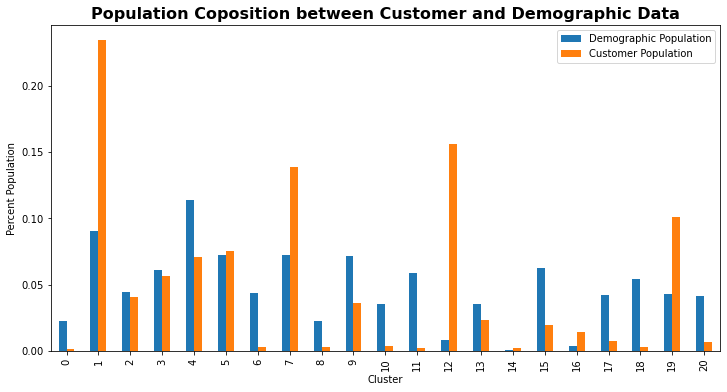

In [308]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
pop_df = pd.concat(
    [pd.Series(global_percent, name='Demographic Population').sort_index(),
     pd.Series(customer_percent, name='Customer Population').sort_index()],
    axis=1
)
pop_df.index.name='Cluster'
pop_df.plot(kind='bar', ax=ax)
ax.set_ylabel('Percent Population')
ax.set_title('Population Coposition between Customer and Demographic Data',
             fontweight='bold',
             fontsize=16)
plt.show()

<AxesSubplot:xlabel='Cluster'>

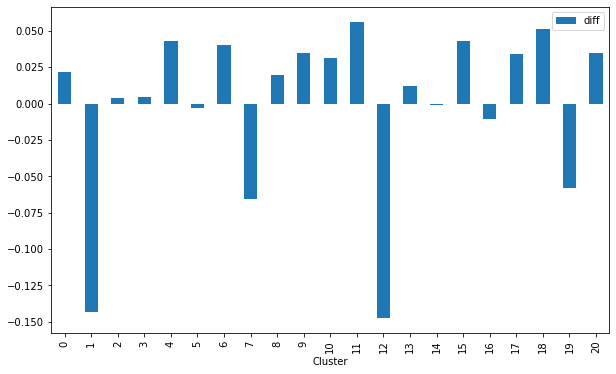

In [316]:
pop_df = pop_df.assign(diff=lambda df: df['Demographic Population'] - df['Customer Population'])
fig, ax = plt.subplots(1,1, figsize=(10,6))
pop_df[['diff']].plot(kind='bar', ax=ax)

In [318]:
pop_df.sort_values('diff')

,Demographic Population,Customer Population,diff
Cluster,,,
12,0.008504,0.156028,-0.147524
1,0.090726,0.234044,-0.143318
7,0.072645,0.138386,-0.065741
19,0.042718,0.101043,-0.058324
16,0.003678,0.014177,-0.010499
5,0.072127,0.075340,-0.003213
14,0.000879,0.002077,-0.001198
2,0.044678,0.040746,0.003933
3,0.060962,0.056310,0.004652


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# Over represented populations in order: 12, 1, 7, 19

In [329]:
for i in (12,):  # 1, 7, 19):
    weight = get_pc_weight(pipeline_pca.components_[i], azdias_clean.columns)
    print(f'\nCorresponding Component Weight for Component {i}:')
    display(weight)


Corresponding Component Weight for Component 12:


NATIONALITAET_KZ_1.0    0.369714
PLZ8_ANTG2              0.184233
OST_WEST_KZ_W           0.184085
BALLRAUM                0.140850
INNENSTADT              0.139466
                          ...   
OST_WEST_KZ_O          -0.184085
ORTSGR_KLS9            -0.188364
NATIONALITAET_KZ_2.0   -0.250959
ARBEIT                 -0.257512
NATIONALITAET_KZ_3.0   -0.266989
Name: mse, Length: 100, dtype: float64

*[ACM] Cluster 12 appears to be related to rural homes likely owned by German-Born 
individuals in former west Germany. For example, `BALLRAUM, INNENSTADT` positively 
coorelate while `ORTSGR_KLS9` negatively coorrelates favoring more rural communities*

In [330]:
for i in (1,):  # 7, 19):
    weight = get_pc_weight(pipeline_pca.components_[i], azdias_clean.columns)
    print(f'\nCorresponding Component Weight for Component {i}:')
    display(weight)


Corresponding Component Weight for Component 1:


ALTERSKATEGORIE_GROB            0.200169
ZABEOTYP_3.0                    0.197493
SEMIO_ERL                       0.183033
FINANZ_VORSORGER                0.177255
RETOURTYP_BK_S                  0.152960
                                  ...   
SEMIO_PFLICHT                  -0.181476
SEMIO_TRADV                    -0.185141
FINANZ_UNAUFFAELLIGER          -0.196759
PRAEGENDE_JUGENDJAHRE_decade   -0.199679
SEMIO_REL                      -0.200806
Name: mse, Length: 100, dtype: float64

*[ACM] Cluster 1 appears to be correlated positively to the indivitual's age
and if they save their finances to be prepared. This group is negatively correlated
with religion, traditional-mindedness, and dutiful-mindedness.*

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



In [ ]:
# Under represented populations in order: 11, 18, 4, 15, 6, 9, ...

In [331]:
for i in (11,):  # 11, 18, 4, 15, 6, 9, ...
    weight = get_pc_weight(pipeline_pca.components_[i], azdias_clean.columns)
    print(f'\nCorresponding Component Weight for Component {i}:')
    display(weight)


Corresponding Component Weight for Component 11:


NATIONALITAET_KZ_1.0    0.271369
REGIOTYP                0.230652
KBA05_ANTG4             0.217748
KKK                     0.213299
PLZ8_HHZ                0.205818
                          ...   
VERS_TYP_2.0           -0.178215
FINANZ_HAUSBAUER       -0.186574
NATIONALITAET_KZ_2.0   -0.209382
LP_STATUS_GROB_2.0     -0.262365
KBA05_ANTG2            -0.266446
Name: mse, Length: 100, dtype: float64

*[ACM] Cluster 11 appears to be related to dense-poor urban homes likely in large family homes 
owned by Foreign-Born individuals. For example, `NATIONALITAET_KZ_1.0, REGIOTYP` positively 
coorelate indicating Foreigh-born in urban environments while `LP_STATUS_GROB_2.0` negatively 
coorrelates favoring more poorer individuals*

In [332]:
for i in (18,):  # 11, 18, 4, 15, 6, 9, ...
    weight = get_pc_weight(pipeline_pca.components_[i], azdias_clean.columns)
    print(f'\nCorresponding Component Weight for Component {i}:')
    display(weight)


Corresponding Component Weight for Component 18:


ANZ_TITEL              0.314187
LP_STATUS_GROB_1.0     0.254809
LP_STATUS_GROB_3.0     0.254676
SHOPPER_TYP_1.0        0.240662
LP_FAMILIE_GROB_2.0    0.228081
                         ...   
LP_FAMILIE_GROB_5.0   -0.144775
SHOPPER_TYP_0.0       -0.152510
FINANZTYP_4.0         -0.188828
LP_STATUS_GROB_4.0    -0.214466
LP_STATUS_GROB_2.0    -0.426434
Name: mse, Length: 100, dtype: float64

*[ACM] Cluster 18 appears to be related to educated, low-to-medium income small family (2) dense-poor urban homes likely in large family homes who tend to shop stressed.*

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

*[ACM] Comparing Correlated Demographics of over and under represented 
populations in the customer dataset, it appears that customers are more likley 
to live in rural communities located in former west Germany owned by older, 
German-born mid-sized families and who considers themselves to be prepared with
their finances. Groups under represented by the customer dataset, seem to be 
both small educated family homes who make low-to-medium incomes and low-income 
large family in dense urban environments.*

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.